In [2]:
# Import Package
import pandas as pd
import numpy as np
import pandas_profiling

from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# pip i ipywidgets


In [3]:
# Load Data

train_online = pd.read_csv('Dataset/train-online_booking_2020.csv')
train_offline = pd.read_csv('Dataset/train-TPK_Hotel_berbintang_2020.csv')

test_online = pd.read_csv('Dataset/test-online_booking_2021.csv')
test_offline = pd.read_csv('Dataset/test-TPK_Hotel_berbintang_2021.csv')
submission = pd.read_csv('Dataset/sample-submission.csv')
print("Data is loaded!")


Data is loaded!


In [4]:
#Report of Data
# train_online_report = pandas_profiling.ProfileReport(train_online)
# test_online_report = pandas_profiling.ProfileReport(test_online)

# train_offline_report = pandas_profiling.ProfileReport(train_offline)
# test_offline_report = pandas_profiling.ProfileReport(test_offline)
# train_online_report

In [5]:
train_online['used_room'] = train_online.room_total - train_online.all_available_room
test_online['used_room'] = test_online.room_total - test_online.all_available_room

encodedCategirical = {"klasifikasi": {"Rated": '1', "Not Rated": '0'}}
train_online = train_online.replace(encodedCategirical)
test_online = test_online.replace(encodedCategirical)

test_online['province'] = test_online['province'].astype('str')
test_online['type'] = test_online['type'].astype('str')
test_online['klasifikasi'] = test_online['klasifikasi'].astype('str')

train_online['tanggal'] = pd.to_datetime(train_online['tanggal'])
test_online['tanggal'] = pd.to_datetime(test_online['tanggal'])


In [6]:
# Now we can agregate them
train_online_agg = train_online \
    .set_index(['tanggal']) \
    .groupby(pd.Grouper(freq='M')) \
    .sum()
test_online_agg = test_online \
    .set_index(['tanggal']) \
    .groupby(pd.Grouper(freq='M')) \
    .sum()



In [7]:
# Menghitung TKP untuk Online

train_online_agg['TPK_Online'] = train_online_agg['used_room'] / train_online_agg['room_total']*100
test_online_agg['TPK_Online'] = test_online_agg['used_room'] /  test_online_agg['room_total']*100


In [8]:
# Membuat Unique ID

train_online_agg = train_online_agg.reset_index()
test_online_agg = test_online_agg.reset_index()

train_online_agg['Id'] = pd.DatetimeIndex(train_online_agg['tanggal']).month
test_online_agg['Id'] = pd.DatetimeIndex(test_online_agg['tanggal']).month


In [9]:
# Join Data

data_train = pd.merge(train_online_agg, train_offline, on='Id', how='inner')
data_predict = pd.merge(test_online_agg, test_offline, on='Id', how='inner')

In [10]:
#Memilih field

data_train_selection = data_train[['TPK_Online', 'TPK']]
data_predict_selection = data_predict[['TPK_Online', 'TPK']]

<AxesSubplot:title={'center':'Log Normal'}, xlabel='TPK'>

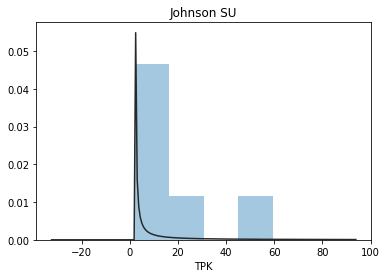

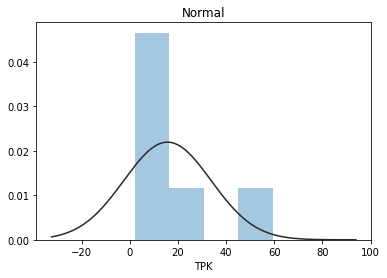

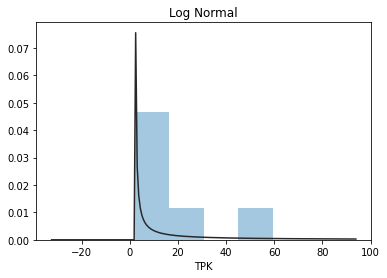

In [11]:
# Mengecek Normalitas Data

y = data_train_selection['TPK']
plt.figure(1)
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2)
plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3)
plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)


<AxesSubplot:title={'center':'Log Normal'}, xlabel='TPK_Online'>

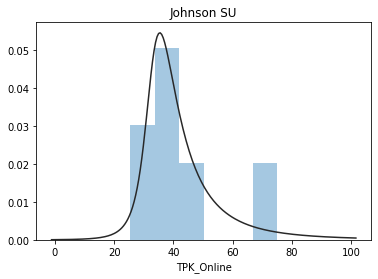

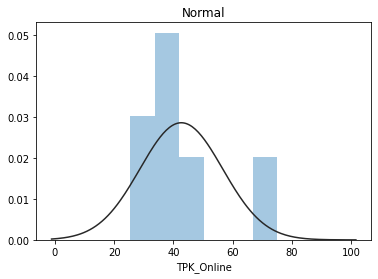

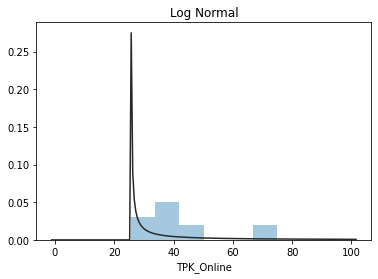

In [12]:
# Mengecek Normalitas Data

x = data_train_selection['TPK_Online']
plt.figure(1)
plt.title('Johnson SU')
sns.distplot(x, kde=False, fit=stats.johnsonsu)
plt.figure(2)
plt.title('Normal')
sns.distplot(x, kde=False, fit=stats.norm)
plt.figure(3)
plt.title('Log Normal')
sns.distplot(x, kde=False, fit=stats.lognorm)


In [13]:
from scipy.stats import kstest, shapiro

print("Data y berdistribusi normal " if(shapiro(data_train_selection['TPK']).pvalue > 0.01) else "Data Y tidak berdistribusi normal" )
print("Data x berdistribusi normal " if(shapiro(data_train_selection['TPK_Online']).pvalue > 0.01) else "Data X tidak berdistribusi normal" )


Data Y tidak berdistribusi normal
Data x berdistribusi normal 


In [35]:
data_train_selection['TPK'] = np.log1p(data_train_selection['TPK'])

In [15]:
# Split Data to train and test

from sklearn.model_selection import train_test_split
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(
    data_train_selection.TPK_Online,
    data_train_selection.TPK,
    test_size=0.17,
    random_state=random_seed
)


In [16]:
X_test,y_test


(10    40.170615
 9     37.940120
 0     74.943540
 Name: TPK_Online, dtype: float64,
 10     9.32
 9      9.53
 0     59.29
 Name: TPK, dtype: float64)

In [17]:
# Scaling Data

from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

scalerX = MinMaxScaler().fit(X_train.values.reshape(-1, 1))
scalery = MinMaxScaler().fit(y_train.values.reshape(-1, 1))

X_train = scalerX.transform(X_train.values.reshape(-1, 1))
y_train = scalery.transform(y_train.values.reshape(-1, 1))

X_test = scalerX.transform(X_test.values.reshape(-1, 1))
y_test = scalery.transform(y_test.values.reshape(-1, 1))


In [18]:
X_test, y_test


(array([[0.34803403],
        [0.29512233],
        [1.17291563]]),
 array([[0.16511045],
        [0.16989296],
        [1.30312002]]))

In [19]:
# Analysis Process

# Default n_splits  = 10
kfolds = KFold(shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


def cv_rmse(model, X=X_train):
    rmse = np.sqrt(-cross_val_score(model, X, y_train,
                   scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)


In [20]:
alphas_alt = [5, 8, 10, 10.1, 10.2, 10.3, 10.35, 10.36, 14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003,
           0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]


In [21]:
ridge = make_pipeline(RobustScaler(), RidgeCV(cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV( cv=kfolds))
svr = make_pipeline(RobustScaler(), SVR(C=20, epsilon=0.005, gamma=0.003,))


In [22]:
gbr = GradientBoostingRegressor()


In [23]:
lightgbm = LGBMRegressor(objective='regression')


In [24]:
xgboost = XGBRegressor( objective='reg:linear', nthread=-1)


In [25]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [26]:
# score = cv_rmse(ridge)
score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()), datetime.now(), )


LASSO: 0.1523 (0.0215)
 2021-09-23 03:35:26.403326
elastic net: 0.1522 (0.0214)
 2021-09-23 03:35:26.919327
SVR: 0.2242 (0.1460)
 2021-09-23 03:35:26.943326
lightgbm: 0.3364 (0.1683)
 2021-09-23 03:35:27.016302
gbr: 0.1493 (0.1525)
 2021-09-23 03:35:27.295310
[03:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:27] WARNING: C:/Users/Adm

In [27]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit((X_train), (y_train))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)


START Fit
stack_gen
[03:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[03:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/

In [28]:
def blend_models_predict(X):
    
    return (
        (0.5 * svr_model_full_data.predict(X)) +
        (0.3 * lasso_model_full_data.predict(X))+
        (0.1 * elastic_model_full_data.predict(X)) +
        (0.1 * ridge_model_full_data.predict(X).flatten())
    )

  


In [29]:
print('Rmse for SVR : ', rmsle(y_test, svr_model_full_data.predict(X_test)))
print('Rmse for Lasso : ', rmsle(y_test, lasso_model_full_data.predict(X_test)))
print('Rmse for Elastic : ', rmsle(y_test, elastic_model_full_data.predict(X_test)))
print('Rmse for Ridge : ', rmsle(y_test, ridge_model_full_data.predict(X_test)))
print('Rmse for XGBoost : ', rmsle(y_test, xgb_model_full_data.predict(X_test)))
print('Rmse for GradientBoosting : ', rmsle(y_test, gbr_model_full_data.predict(X_test)))
print('Rmse for Stack : ', rmsle(y_test, stack_gen_model.predict(X_test)))
print('Rmse for LightGBM : ', rmsle(y_test, lgb_model_full_data.predict(X_test)))


Rmse for SVR :  0.09073124513050822
Rmse for Lasso :  0.09418077444609771
Rmse for Elastic :  0.09431012244525763
Rmse for Ridge :  0.09785897137439839
Rmse for XGBoost :  0.19910008756942138
Rmse for GradientBoosting :  0.1984165657750923
Rmse for Stack :  0.20141021198695447
Rmse for LightGBM :  0.6219808619882929


In [30]:
print('RMSLE score on train data:')
print(rmsle(y_test, blend_models_predict(X_test)))


RMSLE score on train data:
0.09172641752867472


In [31]:
# (10    
#  9     
#  0     
#  Name: TPK_Online, dtype: float64,
#  10     9.32
#  9      9.53
#  0     59.29
#  Name: TPK, dtype: float64)
# (
#     blend_models_predict((np.array([40.170615, 37.940120, 74.943540]).reshape(-1, 1))).reshape(-1, 1))
blend_models_predict(X_test)


array([0.2195806 , 0.16052547, 1.15416882])

In [38]:
from sklearn.preprocessing import MinMaxScaler

print('Predict submission')
submission = pd.read_csv("Dataset/sample-submission.csv")

X_predict = scalerX.transform(data_predict_selection['TPK_Online'].values.reshape(-1, 1))

submission.iloc[:, 1] = scalery.inverse_transform(
    np.expm1(blend_models_predict(X_predict).reshape(-1, 1)))

submission.to_csv('Output/submission-normalized.csv', index=False)
print('Successfully Predicted !')
# np.expm1(minmax_scaler_tpk_online.inverse_transform(blend_models_predict(x_predict).reshape(-1, 1)))


Predict submission


array([[ 9.03442046],
       [12.2979023 ],
       [ 7.94267539],
       [ 8.18941388],
       [ 8.3197057 ],
       [10.05013601]])

array([[ 9.61711748],
       [13.58722255],
       [ 8.35350049],
       [ 8.63634107],
       [ 8.78633927],
       [10.8212847 ]])